# 과제 
- Mnist 데이터를 사용 (8:2 비율로 train set, test set split)
- 원본 데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교
- 지금까지 배웠던 다항 분류기 2개 이상 사용 (KNN, random forest, NB 등등)
- time stamp 찍어서 training 시간과 test accuracy 비교하기

In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
# 데이터 로드
from sklearn.datasets import fetch_mldata
from scipy import io
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#서버 오류 -> 별도로 다운
#mnist = fetch_mldata("MNIST original")
#X = mnist.data / 255.0
#y = mnist.target

#7만개의 작은 숫자 이미지
#행 열이 반대로 되어있음 -> 전치
mnist = io.loadmat('mnist-original.mat') 
X = mnist['data'].T
y = mnist['label'].T

# grayscale 28x28 pixel = 784 feature
# 각 picel은 0~255의 값
# label = 1~10

print (X.shape, y.shape)

(70000, 784) (70000, 1)


In [4]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df['y'] = y
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


# Sampling

In [6]:
df.loc[:10000,'y'].value_counts() # bad

0.0    5923
1.0    4078
Name: y, dtype: int64

In [7]:
df.sample(10000,random_state=7)['y'].value_counts() # not bad

1.0    1100
7.0    1066
3.0    1036
4.0    1031
0.0     976
6.0     976
2.0     974
9.0     968
8.0     942
5.0     931
Name: y, dtype: int64

In [8]:
sample=pd.DataFrame()
for i in range(10) :
    sample=pd.concat([sample,df.query('y==@i').sample(3000,random_state=7)])
sample=sample.reset_index().drop('index',axis=1)

In [9]:
sample['y'].value_counts() # i think it's good

7.0    3000
5.0    3000
9.0    3000
8.0    3000
6.0    3000
4.0    3000
3.0    3000
2.0    3000
1.0    3000
0.0    3000
Name: y, dtype: int64

In [10]:
df=sample.drop('y',axis=1)

In [11]:
target=sample['y']

# Structure

In [12]:
(df.sum()!=0).sum()# 100열 정도가 비어있음

693

In [13]:
(df.apply(min)!=0).sum() #min은 모두 0 

0

In [14]:
(df.apply(max)>255).sum() # max는 모두 255이하

0

# Visualization

<Figure size 432x288 with 0 Axes>

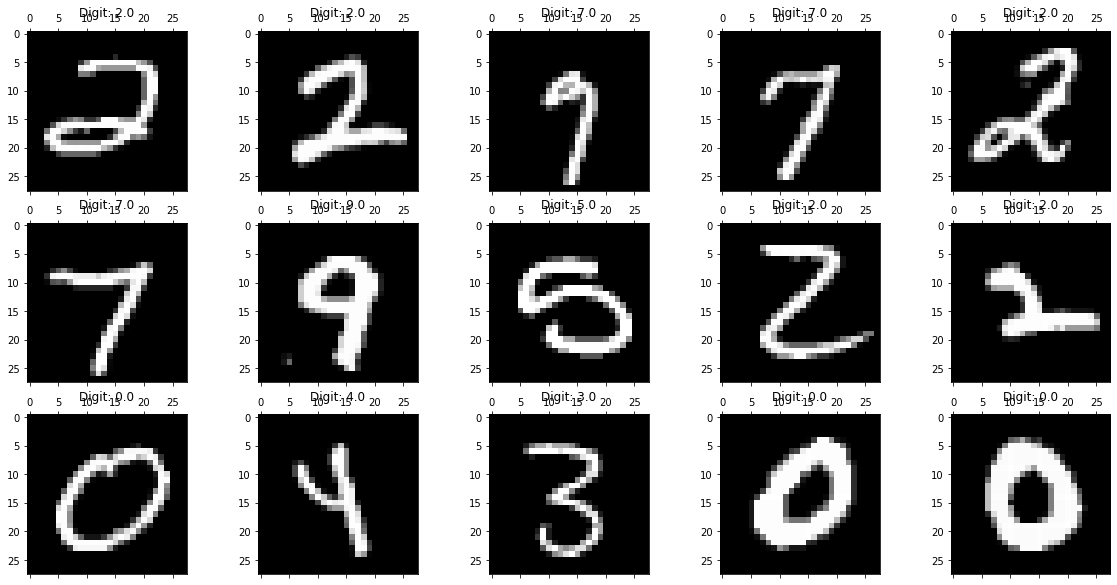

In [67]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt

rndperm = np.random.permutation(df.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(20,10) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(target.loc[rndperm[i]])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=7)

## Plot

In [69]:
def DR_ploting(data,y) :
    fig = plt.figure(figsize=(25,15))
    pca=PCA()
    pca.fit(data)
    lda=LinearDiscriminantAnalysis()
    lda.fit(data,y)
    
    pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
    pca_num_99 = np.argmax(pca_cumsum >= 0.999) + 1
    pca_num_9 = np.argmax(pca_cumsum >= 0.9) + 1
    pca_num_8 = np.argmax(pca_cumsum >= 0.8) + 1 
    
    lda_cumsum = np.cumsum(lda.explained_variance_ratio_)
    lda_num_99 = np.argmax(lda_cumsum >= 0.999) + 1
    lda_num_9 = np.argmax(lda_cumsum >= 0.9) + 1
    lda_num_8 = np.argmax(lda_cumsum >= 0.8) + 1 
    
    plt.subplot(971)
    plt.title('PCA')
    plt.plot(range(pca_num_99),pca_cumsum[:pca_num_99])
    plt.xlabel('Number of Dimension')
    plt.ylabel('Explained_variance_ratio')
    
    plt.subplot(972)
    plt.title('LDA')
    plt.plot(range(lda_num_99),lda_cumsum[:lda_num_99])
    plt.xlabel('Number of Dimension')
    plt.ylabel('Explained_variance_ratio')
    plt.show()
    
    print('PCA 설명량 80% 차원 수   : ',pca_num_8 ,'    LDA 설명량 80% 차원 수   : ',lda_num_8 )
    print('PCA 설명량 90% 차원 수   : ',pca_num_9 ,'    LDA 설명량 90% 차원 수   : ',lda_num_9)
    print('PCA 설명량 99.9% 차원 수 : ',pca_num_99,'   LDA 설명량 99.9% 차원 수 : ',lda_num_99 )
    print('               [원 데이터 차원 수    : ', data.shape[1],']')  

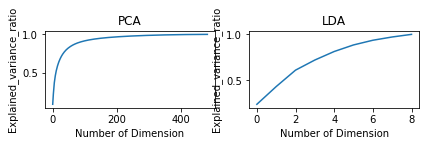

PCA 설명량 80% 차원 수   :  44     LDA 설명량 80% 차원 수   :  5
PCA 설명량 90% 차원 수   :  87     LDA 설명량 90% 차원 수   :  7
PCA 설명량 99.9% 차원 수 :  482    LDA 설명량 99.9% 차원 수 :  9
               [원 데이터 차원 수    :  784 ]


In [70]:
DR_ploting(X_train,y_train)
#lda의 경우는 class 개수 -1 이 적정 차원이라고 한다.

# Dimentionality Reduction

In [138]:
p=PCA(n_components=44)
p.fit(X_train)
X_tr_80p=p.transform(X_train)
X_te_80p=p.transform(X_test)

p=PCA(n_components=87)
p.fit(X_train)
X_tr_90p=p.transform(X_train)
X_te_90p=p.transform(X_test)

p=PCA(n_components=482)
p.fit(X_train)
X_tr_99p=p.transform(X_train)
X_te_99p=p.transform(X_test)

l=LinearDiscriminantAnalysis(n_components=5)
l.fit(X_train,y_train)
X_tr_80l=l.transform(X_train)
X_te_80l=l.transform(X_test)

l=LinearDiscriminantAnalysis(n_components=7)
l.fit(X_train,y_train)
X_tr_90l=l.transform(X_train)
X_te_90l=l.transform(X_test)

l=LinearDiscriminantAnalysis(n_components=9)
l.fit(X_train,y_train)
X_tr_99l=l.transform(X_train)
X_te_99l=l.transform(X_test)

--------------------------------------------
# RF ( Bagging )

In [139]:
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [140]:
def plot_digit(data,size1,size2):
    image = data.reshape(size1, size2)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    cbar = plt.colorbar(ticks=[data.min(), data.max()])
    cbar.ax.set_yticklabels(['Useless', 'Important'])
    plt.show()

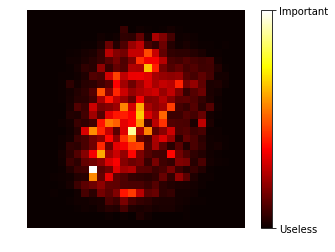

In [141]:
plot_digit(rf.feature_importances_,28,28)

## RF-PCA 

In [142]:
%%time
#기본 데이터
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
display(accuracy_score(pred,y_test))

0.9303333333333333

Wall time: 1.39 s


In [143]:
%%time
rf = RandomForestClassifier(random_state=7)
rf.fit(X_tr_80p,y_train)
pred=rf.predict(X_te_80p)
display(accuracy_score(pred,y_test))

0.9021666666666667

Wall time: 2.9 s


In [144]:
%%time
rf = RandomForestClassifier(random_state=7)
rf.fit(X_tr_90p,y_train)
pred=rf.predict(X_te_90p)
display(accuracy_score(pred,y_test))

0.8781666666666667

Wall time: 2.67 s


In [145]:
%%time
rf = RandomForestClassifier(random_state=7)
rf.fit(X_tr_99p,y_train)
pred=rf.predict(X_te_99p)
display(accuracy_score(pred,y_test))

0.7688333333333334

Wall time: 8.54 s


### Random Forest는 sparse 한 데이터에선 학습이 어려우며 PCA는 분산으로 차원을 축소한다
#### 1) 원본을 제외하고, 낮은 차원으로 축소한 데이터셋에서 더 학습이 잘 이루어 지는듯하며, Target과 관계없는 차원 축소이므로 성능과 항상 비례하는 결과를 보이진 않는 듯 하다
#### 2) 분산 99% 일 때 오래걸리는 이유는 아마 소숫점 자리수가 늘어서인듯
------------------------------------------------------------------------------------------------------------------

## RF-LDA

In [146]:
%%time
rf.fit(X_tr_80l,y_train)
pred=rf.predict(X_te_80l)
display(accuracy_score(pred,y_test))

0.824

Wall time: 538 ms


In [147]:
%%time
rf.fit(X_tr_90l,y_train)
pred=rf.predict(X_te_90l)
display(accuracy_score(pred,y_test))

0.865

Wall time: 542 ms


In [148]:
%%time
rf.fit(X_tr_99l,y_train)
pred=rf.predict(X_te_99l)
display(accuracy_score(pred,y_test))

0.8836666666666667

Wall time: 776 ms


### LDA는 Target 변수에 관하여 차원축소를 진행하므로, 훨씬 더 낮은 차원으로 축소될 수 있으며, 학습또한 용이하다 
#### -> 이로인해 획기적인 시간 단축이 가능했고, 어느정도의 성능또한 확보할 수 있었다.
------------------------------------------------------------------------------------------------------

## LightGBM ( Boosting )

In [149]:
from lightgbm import LGBMClassifier

In [150]:
lgb=LGBMClassifier(random_state=7)

In [151]:
lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [152]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

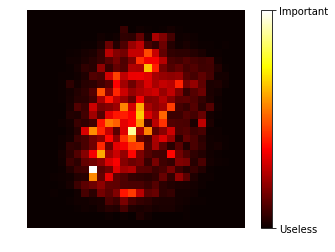

      ↑Random_Forest


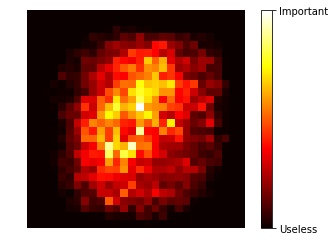

      ↑Light_GBM


In [153]:
plot_digit(rf.feature_importances_,28,28)
print('      ↑Random_Forest')
plot_digit((lgb.feature_importances_/30000),28,28) 
print('      ↑Light_GBM')

## LGB-PCA

In [154]:
%%time
#기본 데이터
lgb = LGBMClassifier(random_state=7)
lgb.fit(X_train,y_train)
pred=lgb.predict(X_test)
display(accuracy_score(pred,y_test))

0.9608333333333333

Wall time: 1min 19s


In [155]:
%%time
lgb.fit(X_tr_80p,y_train)
pred=lgb.predict(X_te_80p)
display(accuracy_score(pred,y_test))

0.9456666666666667

Wall time: 11.1 s


In [156]:
%%time
lgb.fit(X_tr_90p,y_train)
pred=lgb.predict(X_te_90p)
display(accuracy_score(pred,y_test))

0.9448333333333333

Wall time: 20.7 s


In [157]:
%%time
lgb.fit(X_tr_99p,y_train)
pred=lgb.predict(X_te_99p)
display(accuracy_score(pred,y_test))

0.941

Wall time: 1min 49s


### LGB 또한 원본데이터를 제외하고 저 차원일 수록 성능증가, 아마도 sparse한 이미지 데이터이기 때문에 차원축소가 효과가 좋은듯
------------------------------------------------------------------------------------------------------------------

## RF-LDA

In [168]:
%%time
lgb.fit(X_tr_80l,y_train)
pred=lgb.predict(X_te_80l)
display(accuracy_score(pred,y_test))

0.8381666666666666

Wall time: 1.7 s


In [169]:
%%time
lgb.fit(X_tr_90l,y_train)
pred=lgb.predict(X_te_90l)
display(accuracy_score(pred,y_test))

0.877

Wall time: 2.94 s


In [170]:
%%time
lgb.fit(X_tr_99l,y_train)
pred=lgb.predict(X_te_99l)
display(accuracy_score(pred,y_test))

0.8983333333333333

Wall time: 2.64 s


### LDA는 RF와 같은 양상을 보인다